## <center> **Extracting High-res CHM from NAIP Imagery using a Self-supervised Learner** </center>

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the Apache License, Version 2.0
# found in the LICENSE file in the root directory of this source tree.

import os
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchmetrics
from pathlib import Path
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import math
import torchvision.transforms.functional as TF
import torchvision
from torchvision.utils import save_image

from models.backbone import SSLVisionTransformer
from models.dpt_head import DPTHead
import pytorch_lightning as pl
from models.regressor import RNet
from inference import evaluate

### <center> Load quantile predictor weight to normalize aerial images to match satellite image intensities </center>

In [2]:
# 1- load network and its weight to normalize aerial images to match intensities from satellite images. 
norm_path = 'saved_checkpoints/aerial_normalization_quantiles_predictor.ckpt'
ckpt = torch.load(norm_path, map_location='cpu')
state_dict = ckpt['state_dict']
for k in list(state_dict.keys()):
    if 'backbone.' in k:
        new_k = k.replace('backbone.','')
        state_dict[new_k] = state_dict.pop(k)

model_norm = RNet(n_classes=6)
model_norm = model_norm.eval()
model_norm.load_state_dict(state_dict)

<All keys matched successfully>

In [3]:
print(model_norm) # model for normalizing aerial images using satellite image quantiles

RNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (input_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv_block1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_siz

### <center> Build SSL Model </center>

In [4]:
class SSLAE(nn.Module):
    def __init__(self, pretrained=None, classify=True, n_bins=256, huge=False):
        super().__init__()
        if huge == True:
            self.backbone = SSLVisionTransformer(
            embed_dim=1280,
            num_heads=20,
            out_indices=(9, 16, 22, 29),
            depth=32,
            pretrained=pretrained
            )
            self.decode_head = DPTHead(
                classify=classify,
                in_channels=(1280, 1280, 1280, 1280),
                embed_dims=1280,
                post_process_channels=[160, 320, 640, 1280],
            )  
        else:
            self.backbone = SSLVisionTransformer(pretrained=pretrained)
            self.decode_head = DPTHead(classify=classify,n_bins=256)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.decode_head(x) 
        return x

class SSLModule(pl.LightningModule):
    def __init__(self, 
                  ssl_path="compressed_SSLbaseline.pth"):
        super().__init__()
    
        if 'huge' in ssl_path:
            self.chm_module_ = SSLAE(classify=True, huge=True).eval()
        else:
            self.chm_module_ = SSLAE(classify=True, huge=False).eval()
        
        if 'compressed' in ssl_path:   
            ckpt = torch.load(ssl_path, map_location='cpu')
            self.chm_module_ = torch.quantization.quantize_dynamic(
                self.chm_module_, 
                {torch.nn.Linear,torch.nn.Conv2d,  torch.nn.ConvTranspose2d},
                dtype=torch.qint8)
            self.chm_module_.load_state_dict(ckpt, strict=False)
        else:
            ckpt = torch.load(ssl_path)
            state_dict = ckpt['state_dict']
            self.chm_module_.load_state_dict(state_dict)
        
        self.chm_module = lambda x: 10*self.chm_module_(x)
    
    def forward(self, x):
        x = self.chm_module(x)
        return x

In [5]:
# load the model with pre-trained weights for aerial images
model_ssl = SSLModule(ssl_path = 'saved_checkpoints\compressed_SSLhuge_aerial.pth')
print(model_ssl)

c:\Users\zack\anaconda3\envs\hrch\lib\site-packages\torch\_utils.py:314: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


SSLModule(
  (chm_module_): SSLAE(
    (backbone): SSLVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-31): 32 x Block(
          (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): DynamicQuantizedLinear(in_features=1280, out_features=3840, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): DynamicQuantizedLinear(in_features=1280, out_features=1280, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): DynamicQuantized

### <center> Load Sample Dataset </center>

In [6]:
class NeonDataset(torch.utils.data.Dataset):
    path = './data/images/'
    root_dir = Path(path)
    df_path = './data/neon_test_data.csv'
    
    def __init__(self, model_norm, new_norm, src_img='maxar', 
                 trained_rgb= False, no_norm = False,
                **kwargs):
       
        self.no_norm = no_norm
        self.model_norm = model_norm
        self.new_norm = new_norm
        self.trained_rgb = trained_rgb
        self.size = 256
        self.df = pd.read_csv(self.df_path, index_col=0)
        self.src_img = src_img
        
        # number of times crops can be used horizontally
        self.size_multiplier = 6 
        
    def __len__(self):
        if self.src_img == 'neon':
            return 30 * len(self.df) 
        return len(self.df)
        

    def __getitem__(self, i):      
        n = self.size_multiplier 
        ix, jx, jy = i//(n**2), (i%(n**2))// n, (i% (n**2)) % n 
        if self.src_img == 'neon':
            l = self.df.iloc[ix]
        x = list(range(l.bord_x, l.imsize-l.bord_x-self.size, self.size))[jx]
        y = list(range(l.bord_y, l.imsize-l.bord_y-self.size, self.size))[jy]  
        img = TF.to_tensor(Image.open(self.root_dir / l[self.src_img]).crop((x, y, x+self.size, y+self.size)))
        chm = TF.to_tensor(Image.open(self.root_dir / l.chm).crop((x, y, x+self.size, y+self.size)))
        chm[chm<0] = 0
        
        if not self.trained_rgb: ##FIXME data doesn't load when trained_rgb is True
            if self.src_img == 'neon':
                if self.no_norm:
                    normIn = img
                else:
                    if self.new_norm:
                        # image image normalization using learned quantiles of pairs of Maxar/Neon images
                        x = torch.unsqueeze(img, dim=0)
                        norm_img = self.model_norm(x).detach()
                        p5I = [norm_img[0][0].item(), norm_img[0][1].item(), norm_img[0][2].item()]
                        p95I = [norm_img[0][3].item(), norm_img[0][4].item(), norm_img[0][5].item()]
                    else:
                        # apply image normalization to aerial images, matching color intensity of maxar images
                        I = TF.to_tensor(Image.open(self.root_dir / l['maxar']).crop((x, y, x+s, y+s))) 
                        p5I = [np.percentile(I[i,:,:].flatten(),5) for i in range(3)]
                        p95I = [np.percentile(I[i,:,:].flatten(),95) for i in range(3)]
                    p5In = [np.percentile(img[i,:,:].flatten(),5) for i in range(3)]

                    p95In = [np.percentile(img[i,:,:].flatten(),95) for i in range(3)]
                    normIn = img.clone()
                    for i in range(3):
                        normIn[i,:,:] = (img[i,:,:]-p5In[i]) * ((p95I[i]-p5I[i])/(p95In[i]-p5In[i])) + p5I[i]
                  
        return {'img': normIn, 
                'img_no_norm': img, 
                'chm': chm,
                'lat':torch.Tensor([l.lat]).nan_to_num(0),
                'lon':torch.Tensor([l.lon]).nan_to_num(0),
               }

In [7]:
checkpoint = 'saved_checkpoints/compressed_SSLhuge_aerial.pth'
name = 'output_training'
trained_rgb = False # True returns error when loading image batches
normnet = 'saved_checkpoints/aerial_normalization_quantiles_predictor.ckpt'
normtype = 2
display = False
epochs = 2
lr = 0.001
bs = 16

new_norm = True
no_norm = False
if normtype == 0:
    no_norm = True
elif normtype == 1:
    new_norm = False
elif normtype == 2:
    new_norm = True

ds = NeonDataset(model_norm, new_norm, domain='train', src_img='neon', trained_rgb=trained_rgb, no_norm=no_norm)
# subset ds to first 80% of the data
ds = torch.utils.data.Subset(ds, range(int(0.8*len(ds))))
dataloader = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0)

val_ds = NeonDataset(model_norm, new_norm, domain='val', src_img='neon', trained_rgb=trained_rgb, no_norm=no_norm)
# subset val_ds to last 20% of the data
val_ds = torch.utils.data.Subset(val_ds, range(int(0.8*len(val_ds)), len(val_ds)))
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

In [18]:
# print the image names in bathc
print(next(iter(dataloader)).keys())

dict_keys(['img', 'img_no_norm', 'chm', 'lat', 'lon'])


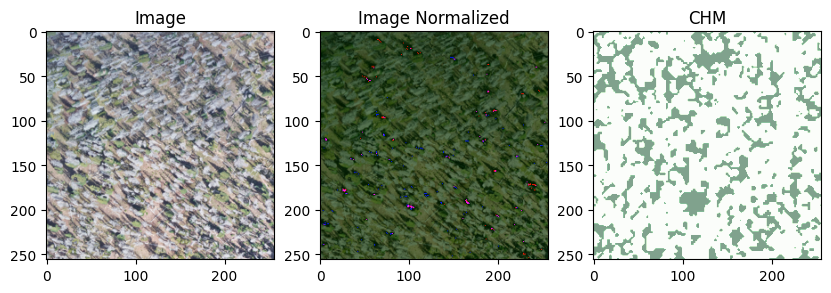

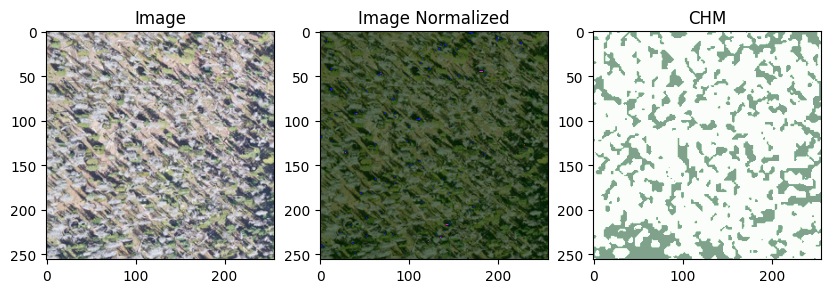

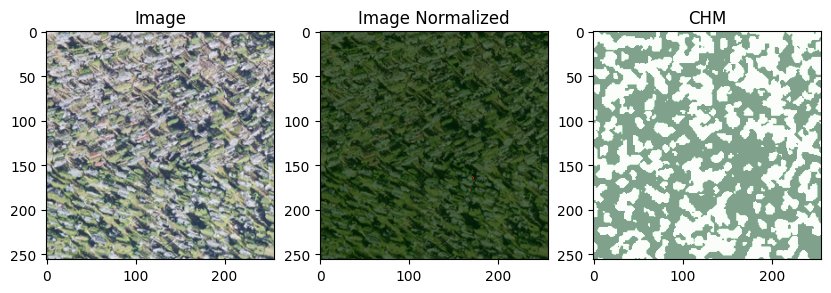

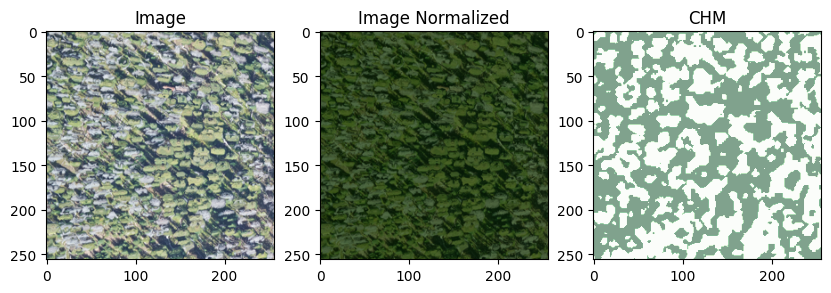

In [21]:
imgs = next(iter(dataloader))['img']
imgs_no_norm = next(iter(dataloader))['img_no_norm']
chms = next(iter(dataloader))['chm']
lats = next(iter(dataloader))['lat']
lons = next(iter(dataloader))['lon']

imgs = list(img for img in imgs)
imgs_no_norm = list(img for img in imgs_no_norm)
chms = list(chm for chm in chms)
lats = list(lat for lat in lats)
lons = list(lon for lon in lons)

# plot image-chm pairs for sample batch
for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs[0].imshow(TF.to_pil_image(imgs_no_norm[i]))
    axs[0].set_title('Image')
    axs[1].imshow(TF.to_pil_image(imgs[i]))
    axs[1].set_title('Image Normalized')
    chm = chms[i][0].numpy()
    chm[chm < 5] = 0 # background
    chm[chm >= 5] = 255 # trees
    axs[2].imshow(chm, cmap='Greens', alpha=0.5)
    axs[2].set_title('CHM')
    # fig.suptitle(f'Latitude: {lats[i].item():.6f}, Longitude: {lons[i].item():.6f}', x=0.5, y=0.66)
    plt.show()

### <center> Train the SSL on Dataset </center>

In [9]:
def train(model, 
          norm, 
          model_norm,
          name, 
          bs=32, 
          trained_rgb=False,
          normtype=2,
          device='cuda', 
          no_norm=False, 
          display=False,
          epochs=10,
          lr=0.001):
    
    dataset_key = 'neon_aerial'    
    
    new_norm = True
    no_norm = False
    if normtype == 0:
        no_norm = True
    elif normtype == 1:
        new_norm = False
    elif normtype == 2:
        new_norm = True
    
    ds = NeonDataset(model_norm, new_norm, domain='train', src_img='neon', trained_rgb=trained_rgb, no_norm=no_norm)
    # subset ds to first 80% of the data
    ds = torch.utils.data.Subset(ds, range(int(0.8*len(ds))))
    dataloader = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0)

    val_ds = NeonDataset(model_norm, new_norm, domain='val', src_img='neon', trained_rgb=trained_rgb, no_norm=no_norm)
    # subset val_ds to last 20% of the data
    val_ds = torch.utils.data.Subset(val_ds, range(int(0.8*len(val_ds)), len(val_ds)))
    val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

    Path('../reports').joinpath(name).mkdir(parents=True, exist_ok=True)
    Path('../reports/'+name).joinpath('results_for_fig_'+dataset_key).mkdir(parents=True, exist_ok=True)
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch in tqdm(dataloader):
            chm = batch['chm'].to(device)
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            
            optimizer.zero_grad()
            outputs = model(norm(batch['img']))
            loss = criterion(outputs, chm)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(dataloader):.4f}")

        running_val_loss = 0.0

        # Evaluate on validation set
        for batch in tqdm(val_dataloader):
            chm = batch['chm'].to(device)
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            
            outputs = model(norm(batch['img']))
            val_loss = criterion(outputs, chm)
            running_val_loss += val_loss.item()
            
            # # Save results for visualization
            # for i in range(len(outputs)):
            #     save_image(outputs[i], f'../reports/{name}/results_for_fig_{dataset_key}/pred_{epoch}_{i}.png')
            #     save_image(batch['img_no_norm'][i], f'../reports/{name}/results_for_fig_{dataset_key}/img_{epoch}_{i}.png')
            #     save_image(chm[i], f'../reports/{name}/results_for_fig_{dataset_key}/gt_{epoch}_{i}.png')
            
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {running_val_loss/len(val_dataloader):.4f}")

        # Save checkpoint
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f'{name}/model_epoch_{epoch+1}.pth')
    
    # Save final model
    torch.save(model.state_dict(), f'{name}/aerial_model_final.pth')

In [10]:
def main():

    checkpoint = 'saved_checkpoints/compressed_SSLhuge_aerial.pth'
    name = 'output_training'
    trained_rgb = False
    normnet = 'saved_checkpoints/aerial_normalization_quantiles_predictor.ckpt'
    normtype = 2
    display = False
    epochs = 2
    lr = 0.001

    if 'compressed' in checkpoint:
        device = 'cpu'
    else:
        device = 'cuda:0'
    os.system("mkdir " + name)
    
    norm_path = normnet 
    ckpt = torch.load(norm_path, map_location='cpu')
    state_dict = ckpt['state_dict']
    for k in list(state_dict.keys()):
        if 'backbone.' in k:
            new_k = k.replace('backbone.', '')
            state_dict[new_k] = state_dict.pop(k)
    
    model_norm = RNet(n_classes=6)
    model_norm = model_norm.eval()
    model_norm.load_state_dict(state_dict)
    
    model = SSLModule(ssl_path=checkpoint)
    model.to(device)
    
    norm = T.Normalize((0.420, 0.411, 0.296), (0.213, 0.156, 0.143))
    norm = norm.to(device)
    
    train(model, norm, model_norm, name=name, bs=16, trained_rgb=trained_rgb, normtype=normtype, device=device, display=display, epochs=epochs, lr=lr)

if __name__ == '__main__':
    main()

100%|██████████| 266/266 [1:36:46<00:00, 21.83s/it]


Epoch [1/2], Training Loss: 3.7396


100%|██████████| 1062/1062 [24:16<00:00,  1.37s/it]


Epoch [1/2], Validation Loss: 9.4535


100%|██████████| 266/266 [1:36:24<00:00, 21.75s/it]


Epoch [2/2], Training Loss: 3.4646


100%|██████████| 1062/1062 [24:03<00:00,  1.36s/it]


Epoch [2/2], Validation Loss: 9.3860


In [49]:
def evaluate(model, 
             norm, 
             model_norm,
             name, 
             bs=32, 
             trained_rgb=False,
             normtype=2,
             device = 'cuda:0', 
             no_norm = False, 
             display = False):
      
    dataset_key = 'neon_aerial'
    
    print("normtype", normtype)    
    
    # choice of the normalization of aerial images. 
    # i- For inference on satellite images args.normtype should be set to 0; 
    # ii- For inference on aerial images, if corresponding Maxar quantiles at the
    # same coordinates are known, args.normtype should be set to 1;
    # iii- For inference on aerial images, an automatic normalization using a pretrained
    # network on aerial and satellite images on Neon can be used: args.normtype should be set to 2 (default); 
    
    new_norm=True
    no_norm=False
    if normtype == 0:
        no_norm=True
    elif normtype == 1:
        new_norm=False
    elif normtype == 2:
        new_norm=True
    
    ds = NeonDataset( model_norm, new_norm, domain='test', src_img='neon', trained_rgb=trained_rgb, no_norm=no_norm)
    dataloader = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0)
        
    Path('../reports').joinpath(name).mkdir(parents=True, exist_ok=True)
    Path('../reports/'+name).joinpath('results_for_fig_'+dataset_key).mkdir(parents=True, exist_ok=True)
    metrics = {}

    # canopy height metrics
    metric_classes = dict(
        mae = torchmetrics.MeanAbsoluteError(),
        rmse = torchmetrics.MeanSquaredError(squared= False),
        r2 = torchmetrics.R2Score(),
        r2_block = torchmetrics.R2Score())
        
    downsampler = nn.AvgPool2d(50)
    bd = 3
    
    preds, chms = [], []
    chm_block_means, pred_block_means = [], []
    
    fig_batch_ind = 0

    for batch in tqdm(dataloader):
        chm = batch['chm'].detach()
        batch = {k:v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        pred = model(norm(batch['img']))
        pred = pred.cpu().detach().relu()
        
        if display == True:
            # display Predicted CHM
            for ind in range(pred.shape[0]):     
                fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
                plt.subplots_adjust(hspace=0.5)
                img_no_norm = batch['img_no_norm'][ind].cpu()
                Inn = np.moveaxis(img_no_norm.numpy(), 0, 2)
                img = batch['img'][ind].cpu()
                I = np.moveaxis(img.numpy(), 0, 2)
                gt = batch['chm'][ind].cpu()
                GT = np.moveaxis(gt.numpy(), 0, 2)
                ax[0].imshow(Inn)
                ax[0].set_title(f"Image",fontsize=12)
                ax[0].set_xlabel('meters')
                ax[1].imshow(I)
                ax[1].set_title(f"Normalized Image ",fontsize=12)
                ax[1].set_xlabel('meters')
                combined_data = np.concatenate((batch['chm'][ind].cpu().numpy(), pred[ind].detach().numpy()), axis=0)
                _min, _max = np.amin(combined_data), np.amax(combined_data)
                pltim = ax[2].imshow(pred[ind][0].detach().numpy(), vmin = _min, vmax = _max)
                ax[2].set_title(f"Pred CHM",fontsize=12)
                ax[2].set_xlabel('meters')
                pltim = ax[3].imshow(GT, vmin = _min, vmax = _max)
                ax[3].set_title(f"GT CHM",fontsize=12)
                ax[3].set_xlabel('meters') 
                cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
                fig.colorbar(pltim, cax=cax, orientation="vertical")
                cax.set_title("meters", fontsize=12) 
                plt.savefig(f"{name}/fig_{fig_batch_ind}_{ind}_{normtype}.png", dpi=300)
            
            fig_batch_ind = fig_batch_ind + 1
        
        chm_block_mean = downsampler(chm[..., bd:, bd:])
        pred_block_mean = downsampler(pred[..., bd:, bd:])
        
        metric_classes['mae'].update(pred, chm)
        metric_classes['rmse'].update(pred, chm)
        metric_classes['r2'].update(pred.flatten(), chm.flatten())
        metric_classes['r2_block'].update(pred_block_mean.flatten(), chm_block_mean.flatten())
    
        preds.append(pred), chms.append(chm)
        chm_block_means.append(chm_block_mean)
        pred_block_means.append(pred_block_mean)
        if display:
            break
    preds, chms = torch.cat(preds), torch.cat(chms)
    
    metrics = {k:v.compute() for k, v in metric_classes.items()}
    torch.save(metrics, f'{name}/metrics.pt')

    #print metrics
    for k, v in metrics.items():
        print(f'{k} {v.item():.2f}')
    print(f"Bias: {(preds.flatten()-chms.flatten()).numpy().mean():.2f}")

In [51]:
def main():
    checkpoint = 'saved_checkpoints/compressed_SSLhuge_aerial.pth'
    name = 'output_inference'
    trained_rgb = False
    normnet = 'saved_checkpoints/aerial_normalization_quantiles_predictor.ckpt'
    normtype = 2
    display = False

    if 'compressed' in checkpoint:
        device='cpu'
    else:
        device='cuda:0'
    
    os.system("mkdir "+name)
    
    # 1- load network and its weight to normalize aerial images to match intensities from satellite images the model was pre-trained on. 
    norm_path = normnet 
    ckpt = torch.load(norm_path, map_location='cpu')
    state_dict = ckpt['state_dict']
    for k in list(state_dict.keys()):
        if 'backbone.' in k:
            new_k = k.replace('backbone.','')
            state_dict[new_k] = state_dict.pop(k)
    
    model_norm = RNet(n_classes=6)
    model_norm = model_norm.eval()
    model_norm.load_state_dict(state_dict)
        
    # 2- load SSL model
    model = SSLModule(ssl_path = checkpoint)
    model.load_state_dict(torch.load('output_training/aerial_model_final.pth')) # replace with custom weights
    model.to(device)
    model.eval()
    
    # 3- image normalization for each image going through the encoder
    norm = T.Normalize((0.420, 0.411, 0.296), (0.213, 0.156, 0.143))
    norm = norm.to(device)
    
    # 4- evaluation 
    evaluate(model, norm, model_norm, name=name, bs=16, trained_rgb=trained_rgb, normtype=normtype, device=device, display=display)

if __name__ == '__main__':
    main()

normtype 2


100%|██████████| 332/332 [1:17:40<00:00, 14.04s/it]


mae 4.58
rmse 6.62
r2 -0.05
r2_block -0.06
Bias: -1.40
